# Análise sobre acumulação de Erro via sensor de Nav. Inercial

## Desenvolvimento do Filtro de Kalman Extendido (EKF)


 ## Desenvolvimento do Arquivo Teste :

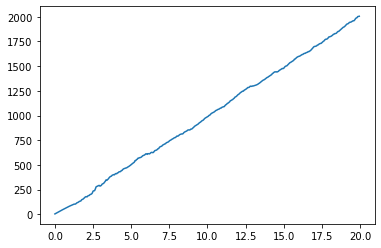

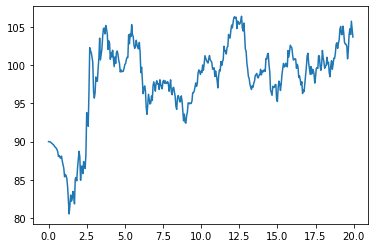

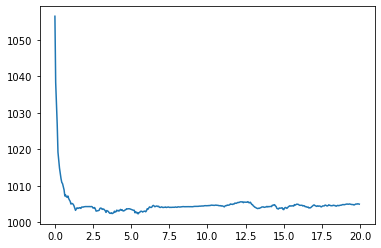

In [1]:
import numpy as np
import RadarEKF as rf
import matplotlib.pyplot as plt


def GetRadar(dt):
    posp = 0
    while True:
        # Estipulate velocity and altitude
        vel = 100  +  5*np.random.randn()
        alt = 1000 + 10*np.random.randn()
        # Refresh position
        pos = posp + vel * dt
        # Read velocity
        v = pos * 0.05 * np.random.randn()
        r = (pos**2 + alt**2)**(0.5) + v
    
        posp = pos
        yield r


# Declare Initial Variables
dt = 0.05
t = np.arange(0,20,dt)
Nsamples = len(t)
Xsaved = np.zeros((3, Nsamples))
Zsaved = np.zeros((1, Nsamples))

# Instantiate Obj. used in this example
measure = GetRadar(dt)
EKF = rf.RadarEKF(dt)

# Foor  loop -> measure 
for k in range(Nsamples):
    # Get position
    r = next(measure)
    
    # Filter usage
    pos, vel, alt = EKF.measure(r)
    Xsaved[:, k] = pos, vel, alt
    
    # Store values
    Zsaved[0, k] = r

# detach Xsaved --> Pos, Vel, Alt
PosSaved = Xsaved[0, :]
VelSaved = Xsaved[1, :]
AltSaved = Xsaved[2, :]

# Plot results
plot, dx = plt.subplots()
plot, dv = plt.subplots()
plot, ax = plt.subplots()

dx.plot(t, PosSaved, '-', label="Position", markersize=0.5)
dv.plot(t, VelSaved, '-', label="Velocity", markersize=0.5)
ax.plot(t, AltSaved, '-', label="Altitude", markersize=0.5)

plt.show()



### Classe RadarEKF

In [74]:
%%writefile RadarEKF.py

import numpy as np

# Jacobian Function Declaration
def Hjacob(xhat):

	x1 = xhat[0, 0]
	x3 = xhat[2, 0]

	H = np.matrix([[0., 0., 0.]])
	H[0, 0] = x1/(x1**2+x3**2)**(1/2)
	H[0, 1] = 0
	H[0, 2] = x3/(x1**2+x3**2)**(1/2)
	
	return H


def hx(xhat):
	x1 = xhat[0, 0]
	x3 = xhat[2, 0]
	zp = np.matrix([[(x1**2 + x3**2)**(1/2)]])

	return zp

class RadarEKF:
	def __init__(self, dt):
        # Declare Member-functions 
		self.A  = np.eye(3) + dt*np.matrix([[0, 1., 0],
											[0, 0 , 0],
											[0, 0 , 0]])
        
        #Measurement Noise Matrix
		self.Q = np.matrix([[0, 0    , 0    ],
							[0, 0.001, 0    ],
							[0, 0    , 0.001]])
        

		self.R = np.matrix([[10]])
        
        # State Matrix
		self.x = np.matrix([[0.0, 90.0, 1100.0]]).getT()
    
        #Measurement (?) Matrix
		self.P = np.eye(3) * 10


	def measure(self, z):
		H  = Hjacob(self.x)
		xp = self.A*self.x
		Pp = self.A * self.P * self.A.getT() + self.Q
		
		K = Pp * H.getT() * np.matrix.getI(H * Pp * H.getT() + self.R)
		
		self.x = xp + K * np.matrix(z - hx(xp))

		self.P = Pp - K * H * Pp

		pos = self.x[0, 0]
		vel = self.x[1, 0]
		alt = self.x[2, 0]
		return pos, vel, alt





Overwriting RadarEKF.py



# DPC++ implementation

In [2]:
%%writefile TestRadarEKF.cpp
#include <iostream>
using std::cout;
using std::endl;

#include <vector>
using std::vector; 

#include <fstream>
using std::ifstream; 
using std::ofstream; 


#include <stdlib.h>
#include <string>
using std::stof;
using std::string;

#include <limits>
#include <random>
#include <CL/sycl.hpp>
#include "oneapi/mkl.hpp"

#include "RadarEKF.h"

namespace blas = oneapi::mkl::blas;
namespace lapack = oneapi::mkl::lapack;




//Function Prototypes
double *GetRadar(int Nsamples,double dt);
void eye(double* A, int l, double a );
void zero(double* A, int l, int m);


int main(){
    //create file : EulerKalman.csv
    ofstream myfile("TestRadarEKF.csv");
    myfile << "time,PosSaved,VelSaved,AltSaved\n";
    auto async_handler = [](sycl::exception_list exceptions) {
        for (exception_ptr const &e : exceptions) {
            try {
                rethrow_exception(e);
            }
            catch (sycl::exception const &e) {
                cout << "Caught asynchronous SYCL exception: " << e.what() << endl;
            }
        }
    };
    
    try {
        
         
        //About Accelerator Device & Queue
        sycl::device device = sycl::device(sycl::default_selector());
        cout << "Device: " << device.get_info<sycl::info::device::name>() << "\n";
        sycl::queue queue(device, async_handler);
        vector<sycl::event> event_list;
        
        
        
        //Declare example variables, lists and Kalman Object
        double dt = 0.05;
        const int Nsamples = 400;
        double t[Nsamples];
        
        double *Radius = GetRadar(Nsamples, dt);
        

        
        
        //Declare Default Matrix, in accord to the Example; 
        
        auto *A = sycl::malloc_shared<double>(3 * 3, queue);
        eye(A,3,1.0); A[1] = dt;
                
        auto *Q = sycl::malloc_shared<double>(3 * 3, queue);
        eye(Q, 3, 0.0001); Q[0] = 0.0; 
        
        auto *R = sycl::malloc_shared<double>(1 * 1, queue);
        R[0] = 10.0;
        
        auto *x = sycl::malloc_shared<double>(3 * 1, queue);
        x[0] = 0.0; x[1] = 90; x[2]  = 1100.0;   
        
        auto *P = sycl::malloc_shared<double>(3 * 3, queue);
        eye(P, 3, 10.0);
        
        auto *z = sycl::malloc_shared<double>(1 * 1, queue);
        
        auto *PosSaved = sycl::malloc_shared<double>(Nsamples, queue);
        auto *VelSaved = sycl::malloc_shared<double>(Nsamples, queue);
        auto *AltSaved = sycl::malloc_shared<double>(Nsamples, queue);
        
        
        RadarEKF *EKF = new RadarEKF();
        
        EKF->setTransitionMatrix(A);
        EKF->setTransitionCovMatrix(Q);
        EKF->setMeasureCovMatrix(R);
        
        EKF->setErrorCovMatrix(P);
        EKF->setSttVariable(x);
        
        
        if (!PosSaved || !VelSaved || !AltSaved) {
            cerr << "Could not allocate memory for vectors." << endl;
            exit(1);
        }
        
        double pos, alt, vel; 
        for (int i = 0; i < Nsamples; i++){  
            //Build up Time array
            t[i] = i*dt;
            //Get Prev. value stored from radar
            z[0] = Radius[i];
            
                                
            EKF->update(z);
            pos = EKF->getResult(0);
            alt = EKF->getResult(1);
            vel = EKF->getResult(2);

            
            //calculate, then store on arrays
            PosSaved[i]   = pos; 
            AltSaved[i]   = alt; 
            VelSaved[i]   = vel; 
            
            //Save the results below in myfile. 
            myfile << t[i] <<", "<< pos << ", " << vel << ", " << alt <<'\n';
        }
        myfile.close();
        free(PosSaved, queue);
        free(VelSaved, queue);
        free(AltSaved, queue);
        
        //EKF.end_task();

    } catch (const exception &e) {
        cerr << "An exception occurred: "
                  << e.what() << endl;
        exit(1);
    }
}



double *GetRadar(int Nsamples,double dt){
	int posp = 0;
	int i = 0; 

	default_random_engine generator;
	normal_distribution<float> distribution(0.0, 1.0);

	double *radar = new double[Nsamples];

	double vel, v, r, alt, pos;
	while (i < Nsamples){ 
		vel = 100  +  0.5*distribution(generator);
        alt = 1000 + 1.0*distribution(generator);
        pos = posp + vel*dt;

        v = pos *.05 * distribution(generator);
        r = sqrt(pos*pos + alt*alt) +v;
        radar[i] = r;
        i++;
        posp = pos;
	}

	return radar;
}

void eye(double* A, int l, double val){
	for(int i =0; i < l; i++){
		for(int j=0; j<l; j++){
			if(i == j) A[j+i*l] = val;
			else A[j+i*l] = 0.0;
		}
	}
}
void zero(double* A, int l, int m){
	for(int i =0; i < l; i++){
		for(int j=0; j<m; j++){
			A[j+i*l] = 0.0;
		}
	}
}



Overwriting TestRadarEKF.cpp


# KalmanTools Class Implementation (DPC++)

In [3]:
%%writefile RadarEKF.h


#include <iostream>
#include <cmath> /* sqrt() */ 

#include <stdlib.h> /* rand()*/

#include <iomanip> /*setw() */

#include <algorithm> 

#include <CL/sycl.hpp>
#include "oneapi/mkl.hpp"



using std::setw;

namespace blas = oneapi::mkl::blas;
namespace lapack = oneapi::mkl::lapack;
using namespace std;

auto nontransM = oneapi::mkl::transpose::nontrans;
auto    transM = oneapi::mkl::transpose::trans;

void inv(sycl::queue &queue, double *A, int64_t N) {
    sycl::event getr_task[2];
    vector<sycl::event> event_list;

    double scratch_size = lapack::getrf_scratchpad_size<double>(queue, N, N, N);
    double *scratchpad = sycl::malloc_shared<double>(scratch_size+1, queue);

    auto *IPIV = sycl::malloc_shared<int64_t>(N*N, queue);
    
    getr_task[0] = lapack::getrf(queue, N, N, A, N, IPIV, scratchpad, scratch_size, event_list);
    getr_task[0].wait();
    getr_task[1] = lapack::getri(queue, N, A, N, IPIV, scratchpad, scratch_size, event_list);
    getr_task[1].wait();
    
    free(IPIV, queue);
} // end Inverse function



void display(double *A, int l, int c){ 
	for(int i = 0; i< l;i++){
		for( int j =0;j<c;j++)
			cout << A[c*i+j] << " ";
		cout << endl;
	}	

}



void Hjacob(double *H, double *xhat){

    double x1 = xhat[0];
    double x3 = xhat[2]; 
    
    //dx(h)
    H[0] = x1 / sqrt(pow(x1, 2.0) + pow(x3, 2.0));
    H[1] = 0.0;
    H[2] = x3 / sqrt(pow(x1, 2.0) + pow(x3, 2.0));
    
    
} // end Hjacob

void Hx(double *zp, double *xhat){
    double x1 = xhat[0];
    double x3 = xhat[2];
    
    zp[0] = sqrt(pow(x1, 2.0) + pow(x3, 2.0));
}// end hx

class RadarEKF {
private: 
    sycl::queue queue;
    double alpha = 1.0; 
    double beta = 0.0;


    //Matrix Pointers
    double *A;
    
    double *Q;
    double *R;
    double *x;
    double *P;
    double *z;


    // Intermediary values to calculus
    int M = 3;
    int L = 1;
    double *H     = sycl::malloc_shared<double>(M * L, queue);
    double *xp    = sycl::malloc_shared<double>(M * L, queue); 
    double *Pp    = sycl::malloc_shared<double>(M * M, queue);
    double *K     = sycl::malloc_shared<double>(M * L, queue);
    double *AP    = sycl::malloc_shared<double>(M * M, queue);   
    double *PpHT  = sycl::malloc_shared<double>(M * L, queue); 
    double *HpHTR = sycl::malloc_shared<double>(L * L, queue);
    double *Hxp   = sycl::malloc_shared<double>(L * L, queue);
    double *KH    = sycl::malloc_shared<double>(M * M, queue); 

public: 
    //modules
    void update(double *);
    double getResult( int );
    
    void setTransitionMatrix(double *Aset);
    void setSttMeasure(double * Hset);
    void setSttVariable(double * xset);
    void setTransitionCovMatrix(double * Qset);
    void setMeasureCovMatrix(double * Rset);
    void setErrorCovMatrix(double * P);

    //void ~RadarEKF()();
};

double RadarEKF::getResult(int l){
    return x[l];
}

void RadarEKF::setTransitionMatrix(double *Aset){
    A = Aset;
}

void RadarEKF::setSttMeasure(double * Hset){
    H = Hset;
}

void RadarEKF::setSttVariable(double * xset){
    x = xset;    
}

void RadarEKF::setTransitionCovMatrix(double * Qset){
    Q = Qset;
}

void RadarEKF::setMeasureCovMatrix(double * Rset){
    R = Rset;
}

void RadarEKF::setErrorCovMatrix(double * Pset){
    P = Pset;
}      


void RadarEKF::update(double *z_input){
    
    
    Hjacob(H, x);     
    z = z_input;
    
    
    constexpr int gemm_total = 10, axpy_total = 5;
    sycl::event gemm_task[gemm_total], scal_task;
    sycl::event axpy_task[axpy_total];
    vector<sycl::event> gemm[gemm_total];
       
     // xp(MxL) = A(MxM) * x(MxL) 
    gemm_task[0] = blas::row_major::gemm(queue, nontransM, nontransM, M, L, M, alpha, A, M, x, L, beta, xp, L, gemm[0]);
    gemm_task[0].wait();
     // Pp(MxM) = A * P * A' + Q(MxM) 
        //1.1) AP(MxM) = A(MxM) * P(MxM)
    gemm_task[1] = blas::row_major::gemm(queue, nontransM, nontransM, M, M, M, alpha, A, M, P, M, beta, AP, M, gemm[1]);
    gemm_task[1].wait();
    
        //1.2) Pp = AP(MxM) * A'(MxM) 
    gemm_task[2] = blas::row_major::gemm(queue, nontransM, transM, M, M, M, alpha, AP, M, A, M, beta, Pp, M, gemm[2]);
    gemm_task[2].wait();
    
    
        //1.3) Pp(MxM) = Pp(MxM) + Q(MxM)  
    axpy_task[0] = blas::axpy(queue, M*M, alpha, Q, 1.0, Pp, 1.0);
    axpy_task[0].wait();
    
    
    // K = Pp * H' * inv(H * Pp * H' + R)
        // 2.1) PpHT(MxL) = Pp(MxM) * Ht(MxL) 
    gemm_task[3] = blas::row_major::gemm(queue, nontransM, transM, M, L, M, alpha, Pp, M, H, M, beta, PpHT, L, gemm[3]);
    gemm_task[3].wait();  
    
    
        // 2.2) HpHTR(LxL) = H(LxM) * [ Pp(MxM) * Ht(MxL) ] = H (LxM) * PpHT(MxL) 
    gemm_task[4] = blas::row_major::gemm(queue, nontransM, nontransM, L, L, M, alpha, H, M, PpHT, L, beta, HpHTR, L, gemm[4]);
    gemm_task[4].wait();

                                       
        // 2.3) HpHTR(LxL) = HpHTR(LxL) + R(LxL)
    axpy_task[1] = blas::axpy(queue, L*L, alpha, R, 1.0, HpHTR, 1.0);
    axpy_task[1].wait();

    
        // HpHTR(LxL) = inv(HpHTR)
    inv(queue, HpHTR, L);                                

         // 2.4) K(MxL) = (Pp(MxM) * Ht(MxM)) * HpHTR(MxM) -> PpHT(MxL) * HpHTR(LxL) 
    gemm_task[5] = blas::row_major::gemm(queue, nontransM, nontransM, M, L, L, alpha, PpHT, L, HpHTR, L, beta, K, L, gemm[5]);
    gemm_task[5].wait();

    
    
    // x(MxK) = xp(MxK) + K * (z - Hx(xp))
        // 3.1) Hxp(LxL) = Hx(xp(MxL))
    Hx(Hxp, xp); 
    
    
        // 3.2) z(LxL) = -Hxp(LxL) + z(LxL)
    axpy_task[2] = blas::axpy(queue, L*L, -alpha, Hxp, 1.0, z, 1.0);
    axpy_task[2].wait();    

    
        //3.3) // x(MxL) = K(MxL)*z(LxL)
    gemm_task[7] = blas::row_major::gemm(queue, nontransM, nontransM, M, L, L, alpha, K, L, z, L, beta, x, L, gemm[7]);
    gemm_task[7].wait();
 
    
    
    
        //3.4) x(MxL) = xp(MxL) + x(MxL)
    axpy_task[3] = blas::axpy(queue, M*L, alpha, xp, 1.0, x, 1.0);
    axpy_task[3].wait();
    
    
    
    // P = Pp - K * H * Pp
        //4.1) KH(MxM) = K(MxL) * H(LxM)
    gemm_task[8] = blas::row_major::gemm(queue, nontransM, nontransM, M, M, L, alpha, K, L, H, M, beta, KH, M, gemm[8]);
    gemm_task[8].wait();
 
    
        //4.2) P(MxM) =(-1)* KH(MxM) * Pp(MxM) 
    gemm_task[9] = blas::row_major::gemm(queue, nontransM, nontransM, M, M, M, -alpha, KH, M, Pp, M, beta, P, M, gemm[9]);
    gemm_task[9].wait();
    
        //4.3) P(MxM) = (Pp - P) 
    axpy_task[4] = blas::axpy(queue, M * M, alpha, Pp, 1.0, P, 1.0);
    axpy_task[4].wait();

    
    
    //End calculus here, then its necessary to acess it by GetResult, 
    //which is obtained by the matrix X(nRow x nCol).
    
    
}    



/*
RadarEKF::~RadarEKF(){
    free(A, queue);
    free(H, queue);
    free(Q, queue);
    free(R, queue);
    free(x, queue);
    free(P, queue);
    free(z, queue);

    free(xp, queue);
    free(Pp, queue);
    free(K, queue);
    free(AP, queue);
    free(PpHT, queue);
    free(HpHTR, queue);
    free(Hxp, queue);
    free(Kz, queue);
    free(KH, queue);
    
}
*/



Overwriting RadarEKF.h


# CPU execution

dpcpp TestRadarEKF.cpp -o TestRadarEKF -DMKL_ILP64  -I"/glob/development-tools/versions/oneapi/2022.1.2/oneapi/mkl/2022.0.2/include" -fsycl-device-code-split=per_kernel -L/glob/development-tools/versions/oneapi/2022.1.2/oneapi/mkl/2022.0.2/lib/intel64 -lmkl_sycl -lmkl_intel_ilp64 -lmkl_sequential -lmkl_core -lsycl -lOpenCL -lpthread -lm -ldl
./TestRadarEKF
Device: Intel(R) Xeon(R) Gold 6128 CPU @ 3.40GHz


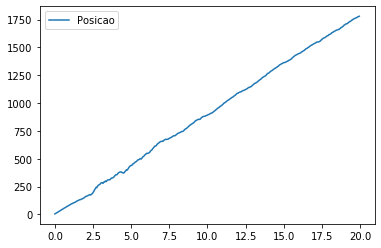

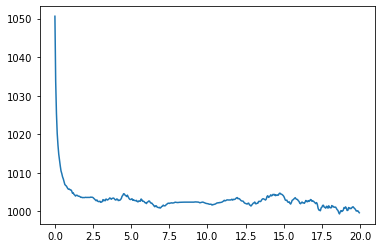

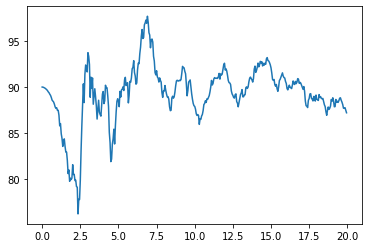

In [2]:
! make 
! mv TestRadarEKF.csv TestRadarEKF_CPU.csv
import matplotlib.pyplot as plt
import pandas as pd


def plot_results(filename):
    df = pd.read_csv(filename)
    
    plot_1, ax = plt.subplots()
    plot_2, ay = plt.subplots()
    plot_3, az = plt.subplots()

    ax.plot(df.time.to_list(), df.PosSaved.to_list(), '-', label="Posicao")
    ay.plot(df.time.to_list(), df.VelSaved.to_list(), '-', label="Velocidade")
    az.plot(df.time.to_list(), df.AltSaved.to_list(), '-', label="Altitude")
    
    #ax.set(title="Velocity Label", xlabel="Time [sec]", ylabel="Velocity [M/s]")
    #ax.set(title="Position Label", xlabel="Horizontal [Pixels]", ylabel="Vertical [Pixels]")
    ax.legend()

plot_results('TestRadarEKF_CPU.csv')


# GPU execution

Job has been submitted to Intel(R) DevCloud and will execute soon.

 If you do not see result in 60 seconds, please restart the Jupyter kernel:
 Kernel -> 'Restart Kernel and Clear All Outputs...' and then try again

Job ID                    Name             User            Time Use S Queue
------------------------- ---------------- --------------- -------- - -----
1863777.v-qsvr-1           ...ub-singleuser u114416         00:01:04 R jupyterhub     
1863799.v-qsvr-1           build_run.sh     u114416         00:11:13 R batch          
1863800.v-qsvr-1           build_run.sh     u114416         00:09:08 R batch          
1863804.v-qsvr-1           build_run.sh     u114416                0 Q batch          

Waiting for Output ██████████████████████████████ Done⬇

########################################################################
#      Date:           Fri 11 Mar 2022 11:43:13 AM PST
#    Job ID:           1863804.v-qsvr-1.aidevcloud
#      User:           u114416
# Resources:   

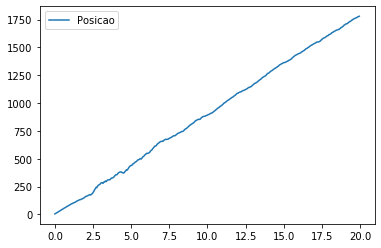

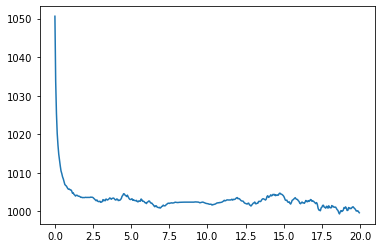

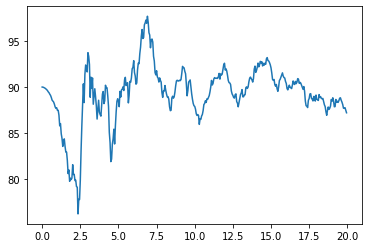

In [3]:
! chmod 755 q; chmod 755 build_run.sh; if [ -x "$(command -v qsub)" ]; then ./q build_run.sh; else ./build_run.sh; fi
! mv TestRadarEKF.csv TestRadarEKF_GPU.csv

plot_results('TestRadarEKF_GPU.csv')